In [41]:
import pandas as pd
import riskfolio as rp
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import warnings
warnings.filterwarnings('ignore')

from fredapi import Fred
key=''

fred = Fred(api_key=key)

# Regime based asset allocation

* Prediction with Random Forest and Genetic Algorithm (in the other notebooks)
    * Inflation 12 months ahead YoY inflation and Recession nowcasting (for out-of sample regime classification)
    * One-month ahead asset returns
* Define the economics regimes
* Bayesian inference to combine predictions and past returns
* Mean-CDaR Portfolio Optimization
* Backtest

Data sources: Fred, Yahoo Finance



## Regimes

In [42]:
data={}
codes={'Inflation': 'CPIAUCSL','Recession':'USRECD','Infl Expectations': 'EXPINF1YR'}

for i in codes.values():
    data[i]=fred.get_series(i)

In [43]:
df=pd.DataFrame.from_dict(data).dropna()
df.columns=codes.keys()
df['Inflation']=df['Inflation'].pct_change(12)*100
df.dropna(inplace=True)
df['Infl Expectations']=df['Infl Expectations'].shift(12)

predicted=pd.read_csv('predicted.csv',parse_dates=True,index_col=0)
predicted.columns=['Predicted']
df=df.join(predicted)


df=df.join(pd.read_csv('recession.csv',parse_dates=True,index_col=0)['Nowcasting'])

In [44]:
split='2007-05-01'
df_test=df.loc[split:]
df_train=df.loc[:split]

<AxesSubplot:>

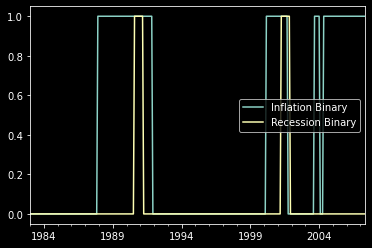

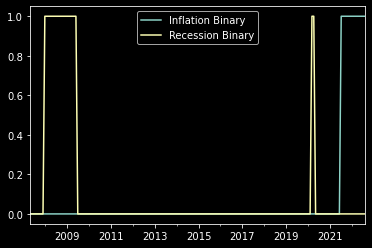

In [45]:
df_train['Inflation Binary']=pd.get_dummies(df_train['Infl Expectations'].rolling(12).mean()<df_train['Inflation'].rolling(12).mean(),drop_first=True)
df_train['Recession Binary']=df_train['Recession']

df_test['Inflation Binary']=pd.get_dummies(df_test['Infl Expectations'].rolling(12).mean()+2<df_test['Predicted'].rolling(4).mean(),drop_first=True)
df_test['Recession Binary']=pd.get_dummies(df_test['Nowcasting']>0.5,drop_first=True)


df_train[['Inflation Binary','Recession Binary']].plot()
df_test[['Inflation Binary','Recession Binary']].plot()


In [47]:
df_=pd.concat([df_train[['Inflation Binary','Recession Binary']],df_test[['Inflation Binary','Recession Binary']].iloc[1:]])

regimi=pd.DataFrame(['Recessione', 'Stagflazione', 'Crescita', 'Crescita inflazionistica'],columns=['Regimi'])
regimi

,Regimi
0,Recessione
1,Stagflazione
2,Crescita
3,Crescita inflazionistica


<AxesSubplot:>

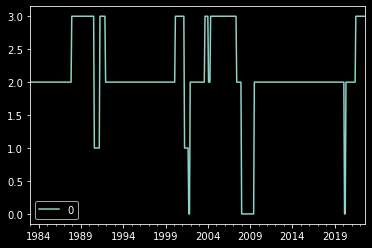

In [48]:
regimes=np.zeros(len(df_))
regimes[np.logical_and(df_['Inflation Binary']==1,df_['Recession Binary']==1)]=1
regimes[np.logical_and(df_['Inflation Binary']==0,df_['Recession Binary']==0)]=2
regimes[np.logical_and(df_['Inflation Binary']==1,df_['Recession Binary']==0)]=3

pd.DataFrame(regimes,index=df_.index).plot()

## Bond TR index

In [49]:
import yfinance
assets={'Gold': '^XAU','10 years':'^TNX','5 years': '^FVX','S&P500':'^GSPC','Commodities':'^SPGSCI','Cash':'^IRX'}
assets=dict(sorted(assets.items(), key=lambda item: item[1]))
data_=yfinance.download(list(assets.values()))['Adj Close'].dropna()

[*********************100%***********************]  6 of 6 completed


Following Swinkels (2019):

Given the yield-to-maturity and remaining maturity, the interest rate sensitivity or modified duration of a risk-free bond at par value can be approximated by
$$
D_{\mathfrak{t}}\left(Y_t, M_t\right)=1 / Y_t \cdot\left[1-1 /\left(1+0.5 \cdot Y_t\right)^{2 \cdot M}{ }_t\right],
$$
with $Y_t$ the yield-to-maturity at time $t$ and $M_t$ the remaining maturity of the bond at time $t$. The convexity $C_t$ of a par bond, which measures the non-linear relationship between the price and yield of a bond can be approximated with
$$
\left.C_t\left(Y_t, M_t\right)=2 /\left(Y_{\mathrm{t}}^2\right) \cdot\left[1-1 /\left(1+0.5 \cdot Y_{\mathrm{t}}\right)^{2 \cdot M t}\right)\right]-\left(2 \cdot M_t\right) /\left[Y_t \cdot\left(1+0.5 \cdot Y_t\right)\right]^{2 \cdot M_t+1} .
$$
For better approximations, the dispersion in maturity of the bond portfolio is needed as an input, which we do not have available. Now, we can calculate the investment return over period $t$ when we know the yield at the beginning and the end of the period, and the maturity of the bond
$$
R_t\left(Y_{\mathrm{t}-1}, Y_t, M_t\right)=Y_{\mathrm{t}-1}-D_t \cdot\left(Y_t-Y_{t-1}\right)+\frac{1}{2} \cdot C_{\mathrm{t}} \cdot\left(Y_{\mathrm{t}}-Y_{t-1}\right)^2
$$

In [50]:
def bond_tr(y,m,k=(1/252)):
    z=1+y*0.5
    duration=(1-1/(z**(2*m)))/y
    convexity=(2/(y**2))*(1-1/(z**(2*m)))-(2*m)/(y*(z)**(2*m))
    b_rets=(1+y)**(1/252)-1-duration*(y-y.shift(1))+0.5*convexity*((y-y.shift(1))**2)
    return (1+b_rets).cumprod()

<AxesSubplot:xlabel='Date'>

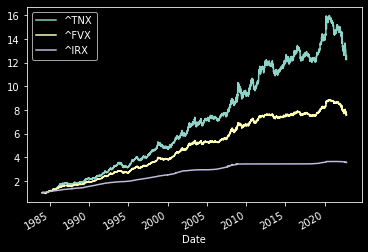

In [51]:
data_['^TNX']=bond_tr(data_['^TNX']/100,10)
data_['^FVX']=bond_tr(data_['^FVX']/100,5)
data_['^IRX']=bond_tr(data_['^IRX']/100,1,k=(91/252))

data_[['^TNX','^FVX','^IRX']].plot()

## Returns analysis

In [52]:
returns=data_.resample('W').ffill().join(pd.DataFrame(regimes,index=df_.index).resample('W').ffill())
returns.iloc[:,:6]=returns.iloc[:,:6].pct_change()
returns.columns=list(assets.keys())+['Regime']
returns.dropna(inplace=True)

In [53]:
returns_train=returns[returns.index < split]
returns_test=returns[returns.index > split]

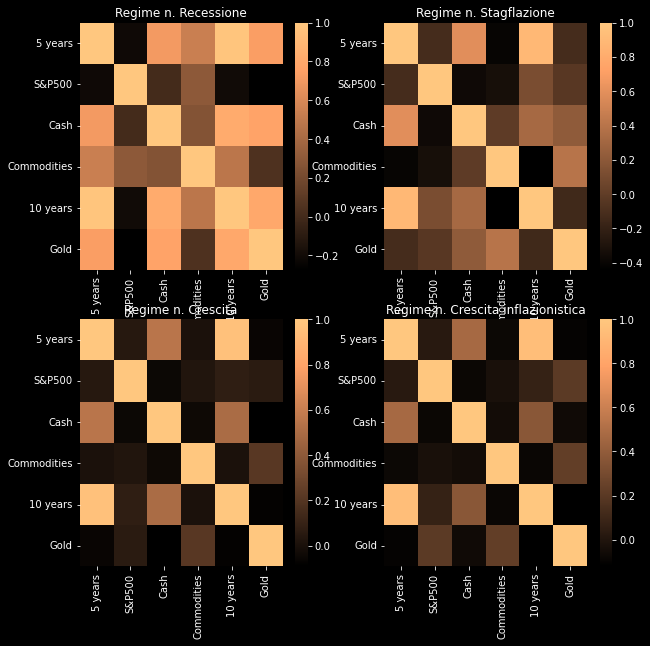

In [54]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    sns.heatmap(returns_train[returns_train['Regime']==i].drop('Regime',axis=1).corr(),cmap='copper',ax=ax)
    plt.title('Regime n. '+str(regimi.iloc[i].values[0]))

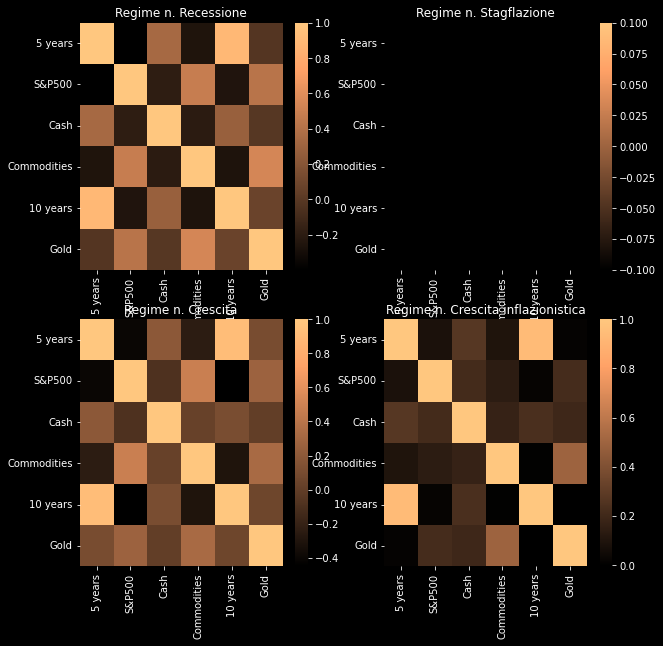

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    sns.heatmap(returns_test[returns_test['Regime']==i].drop('Regime',axis=1).corr(),cmap='copper',ax=ax)
    plt.title('Regime n. '+str(regimi.iloc[i].values[0]))

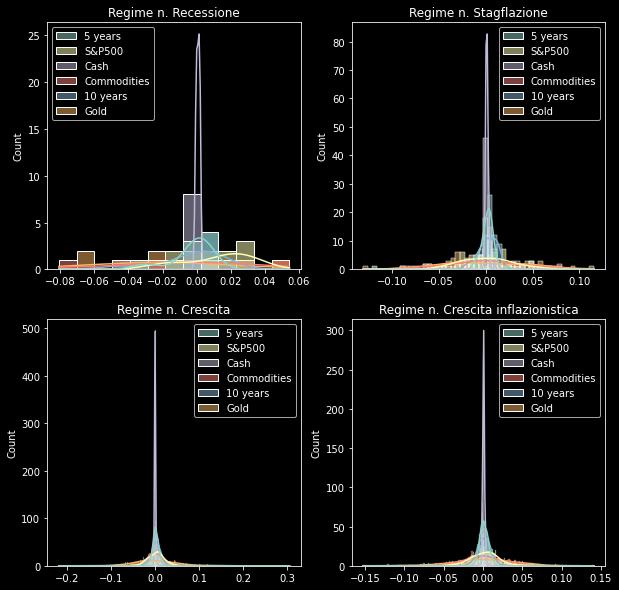

In [56]:
fig = plt.figure(figsize=(10, 10))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    sns.histplot(returns_train[returns_train['Regime']==i].drop(['Regime'],axis=1),kde='True',ax=ax)
    plt.title('Regime n. '+str(regimi.iloc[i].values[0]))

# Bayesian inference


Let's assume that the asset's returns follow a multivariate Gaussian distribution with an uncertain mean which every investor have to estimate. Therefore, we express our predictions based on Random Forest as:
$$
f_{p r}(\mu) \sim N\left(\mu_0, \Psi_0\right)
$$
where $\mu_0$ e $\Psi_0$ are the mean and variance of the prior distribution. The variance/covariance matrix $\Psi_0$ rapresent the uncertainity about the mean $\mu_0$ and is computed on residual errors of the regressor. 
Then the prior density can be expressed as:
$$
f_{p r}(\mu) \propto \exp \left\{-\frac{1}{2}\left(\mu-\mu_0\right)^{\prime} \Psi_0^{-1}\left(\mu-\mu_0\right)\right\}
$$

And the conditional likehood as:
$$
f(\mathbf{Y} \mid \mu, \Sigma) \propto \exp \left\{-\frac{1}{2}(\mu-\widehat{\mu})^{\prime} T \Sigma^{-1}(\mu-\widehat{\mu})\right\}
$$

 Applying Gauss theorem we obtain:
 $$
f_{p o}\left(\mu_1 \mid \mathbf{Y}, \Sigma_1\right) \propto \exp \left\{-\frac{1}{2}\left(\mu-\mu_1\right)^{\prime} \Sigma_1^{-1}\left(\mu-\mu_1\right)\right\}
$$

$$
\begin{aligned}
\mu_1 &=\left[\Psi_0^{-1}+T \Sigma^{-1}\right]^{-1}\left(\Psi_0^{-1} \mu_0+T \Sigma^{-1} \widehat{\mu}\right) \\
\Sigma_1 &=\left[\Psi_0^{-1}+T \Sigma^{-1}\right]^{-1}
\end{aligned}
$$

Which implies:
$$
f\left(R_{t+1} \mid \mu, \Sigma\right) \sim N\left(\mu_1, \Sigma+\Sigma_1\right)
$$

In [57]:
xgb=(pd.read_csv('predictions.csv',index_col=0,parse_dates=True).resample('W').ffill()/100+1)**(1/(4*5))-1
returns=returns.join(xgb).dropna()

In [58]:
def posterior(returns,i):
    from scipy.stats import gmean
    rets=returns.iloc[:i][returns['Regime'].iloc[:i]==returns.iloc[i]['Regime']].drop('Regime',axis=1)
    likehood=np.array(rets.iloc[:,:6])
    prior=np.array(rets.iloc[:,6:])
    mu_0=(prior[-1])

    cov_0=pd.DataFrame((np.roll(likehood,-4)-prior)).cov()

    mu_l=gmean(likehood+1)-1
    sigma_l=pd.DataFrame(likehood).cov()
    n=rets.shape[0]

    mu1=np.linalg.inv(np.linalg.inv(cov_0)+n*np.linalg.inv(sigma_l))@(np.linalg.inv(cov_0)@mu_0+n*np.linalg.inv(sigma_l)@mu_l)
    sigma1=np.linalg.inv(np.linalg.inv(cov_0)+n*np.linalg.inv(sigma_l))
    sigma_pred=sigma1+sigma_l

    return mu1, sigma_l


In [59]:
postmu,postvar,dates=[],[],[]
start=returns.reset_index()[returns.index>=returns_test.index[0]].index[0]
for i in range(start,len(returns)):
    if returns.iloc[i].name.month!=returns.iloc[i-1].name.month:
        mu,var=posterior(returns,i)
        postmu.append(mu)
        postvar.append(var)
        dates.append(returns.iloc[i].name)

## Last predictions

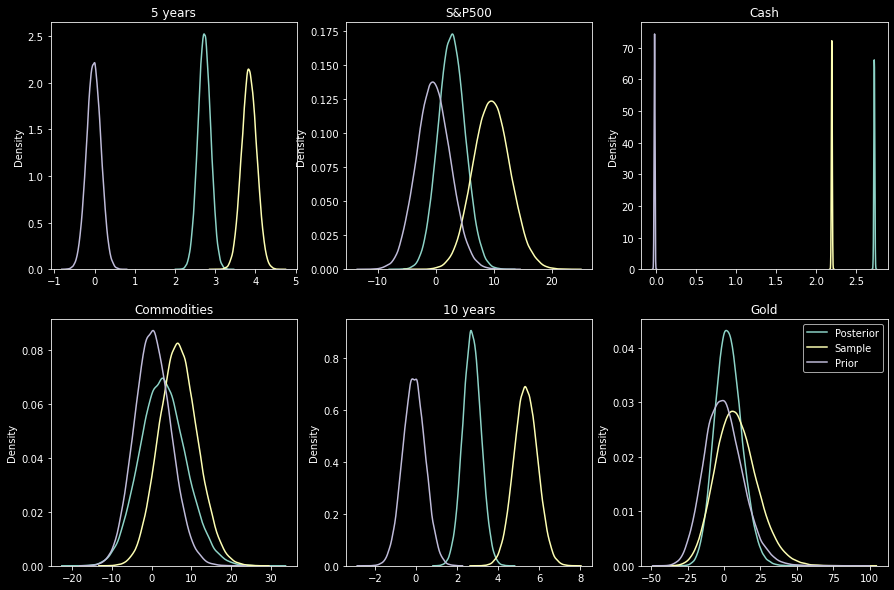

In [60]:
fig = plt.figure(figsize=(15, 10))

for i in range(0,6):
    ax = fig.add_subplot(2,3,i+1)
    x = (np.random.normal(postmu[-1][0],postvar[-1][i][i],size=100000)+1)**(52)-1
    y = (np.random.normal(np.array(returns.iloc[:,i].mean()),returns.iloc[:,i].var(),size=100000)+1)**(52)-1
    z=(np.random.normal(np.array(returns.iloc[-1,i+7]),pd.DataFrame((np.roll(returns.iloc[:,i],-4)-returns.iloc[:,i+7])).var()[0],size=100000)+1)**(52)-1
    sns.kdeplot(x*100,label='Posterior',ax=ax)
    sns.kdeplot(y*100,label='Sample',ax=ax)
    sns.kdeplot(z*100,label='Prior',ax=ax)
    plt.title(list(assets.keys())[i])
plt.legend()
plt.show()

# Portfolio Optimization

$$
\operatorname{CDaR}_\alpha(X)=\operatorname{DaR}_\alpha(X)+\frac{1}{\alpha T} \sum_{j=0}^T \max \left[\max _{t \in(0, j)}\left(\sum_{i=0}^t X_i\right)-\sum_{i=0}^j X_i-\operatorname{DaR}_\alpha(X), 0\right]
$$

$$
\begin{array}{ll}
\max _w & R(w)-\lambda \operatorname{CDaR}_\alpha(w) \\
\text { s.t. } & A w \geq B \\
\end{array}
$$

In [61]:
asset_classes = {'Assets': assets.keys(), 
                 'Type': ['Bond','Stock','Cash','Commodities','10 Year','Gold']}
asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])
constraints = {'Disabled': [False,],'Type': ['Classes'],'Set': ['Type'],'Position': ['Cash'],'Sign': ['<='], 'Weight': [0],'Type Relative': [''],'Relative Set': [''],'Relative': [''],'Factor': ['']}
constraints = pd.DataFrame(constraints)
A, B = rp.assets_constraints(constraints, asset_classes)

In [62]:
import riskfolio as rp
w=[]
c=0
for i in tqdm(range(start, len(returns))):
    if returns.iloc[i].name.month!=returns.iloc[i-1].name.month:
        port=rp.Portfolio(returns[returns['Regime']==returns['Regime'].iloc[i]].iloc[:i,:6])
        port.mu=pd.DataFrame(postmu[c]).T
        port.cov=pd.DataFrame(postvar[c])
        port.ainequality = A
        port.binequality = B
        w.append(port.optimization(obj='Utility',rm='CDaR'))
        c+=1

100%|██████████| 797/797 [00:06<00:00, 118.55it/s]


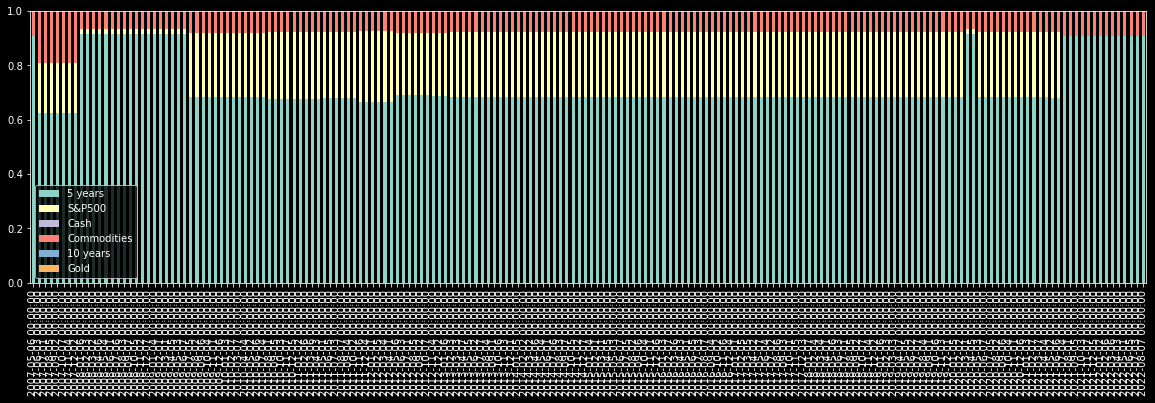

In [63]:
weights=pd.DataFrame(np.concatenate(w,axis=1),index=returns.columns[:6],columns=dates).T
weights.plot.bar(stacked=True,figsize=(20,5))
plt.show()

# Backtest

In [64]:
def drawdown(x):
    return (x-x.expanding().max())/x

def stats(hist,m=52):
    so=sortino(hist)
    std=hist.pct_change().std()[0]*(m**0.5)
    cagr=(((hist.iloc[-1]/hist.iloc[0])**(m/len(hist))-1)).values[0]
    sh=cagr/std
    dd=((hist-hist.expanding().max())/hist.expanding().max()).mean()[0]
    return cagr,std,sh,dd,so
    
def sortino(df,m=52):
    df=df.iloc[:,0]
    expected_return = (df[-1]/df[0])**(m/len(df))-1
    df=df.pct_change().dropna()
    downside_returns = df.loc[df < 0]
    down_stdev = downside_returns.std()*(m**0.5)
    sortino_ratio = (expected_return)/down_stdev
    return sortino_ratio

In [65]:
weights_w=weights.resample('W').ffill()

In [66]:
ptfr=(returns.iloc[:,:6].loc[weights_w.index]*weights_w).sum(axis=1)
static=(returns.iloc[:,:6].loc[split:].multiply([0.3,0.4,0.1,0,0.3,0]).sum(axis=1)+1).cumprod()

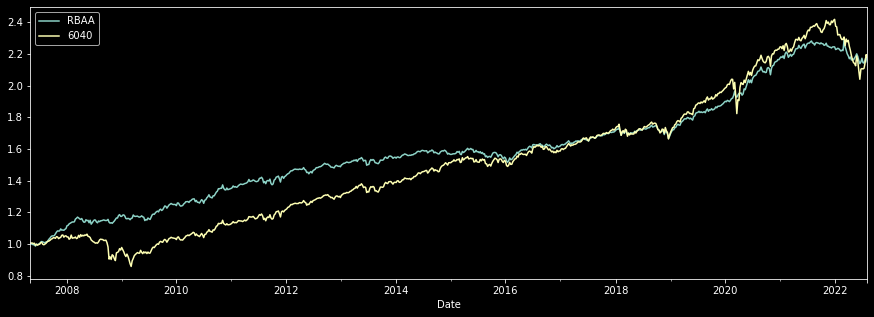

In [67]:
fig = plt.figure(figsize=(15, 5))

ptf=(ptfr+1).cumprod()
ptf.plot(label='RBAA')
static.plot(label='6040')
plt.legend()

In [68]:
portf=[pd.DataFrame(ptf),(returns_test[['S&P500']]+1).cumprod()*100,pd.DataFrame(static),]
st=[]
for i in portf:
    st.append(stats(i))
res=pd.DataFrame(st,index=['RBAA','SP500','6040'],columns=['CAGR','STD','Sharpe','avgDD','Sortino' ])

<AxesSubplot:>

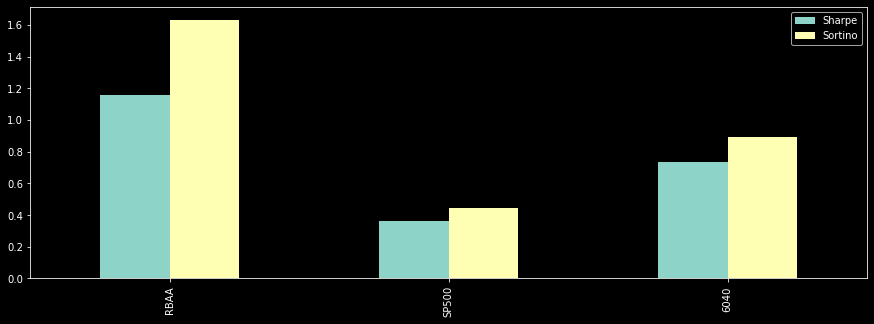

In [69]:
res[['Sharpe','Sortino']].plot.bar(figsize=(15,5))

<AxesSubplot:>

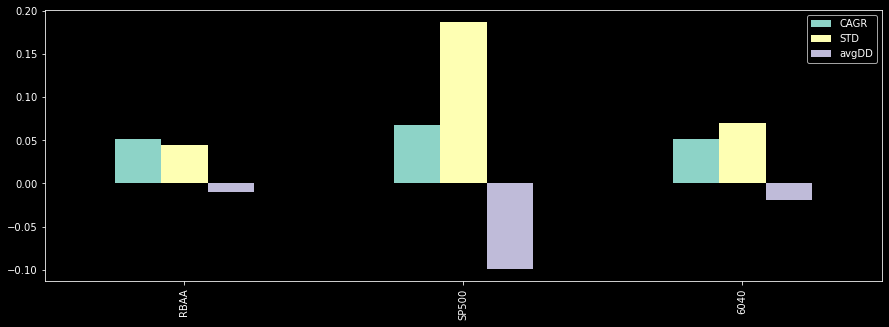

In [70]:
res[['CAGR','STD','avgDD']].plot.bar(figsize=(15,5))